Epoch [1/1], Step [1/1875], Loss: 1.2402
Epoch [1/1], Step [101/1875], Loss: 0.2575
Epoch [1/1], Step [201/1875], Loss: 0.1934
Epoch [1/1], Step [301/1875], Loss: 0.1467
Epoch [1/1], Step [401/1875], Loss: 0.1116
Epoch [1/1], Step [501/1875], Loss: 0.0779
Epoch [1/1], Step [601/1875], Loss: 0.0804
Epoch [1/1], Step [701/1875], Loss: 0.0635
Epoch [1/1], Step [801/1875], Loss: 0.0623
Epoch [1/1], Step [901/1875], Loss: 0.0530
Epoch [1/1], Step [1001/1875], Loss: 0.0502
Epoch [1/1], Step [1101/1875], Loss: 0.0467
Epoch [1/1], Step [1201/1875], Loss: 0.0416
Epoch [1/1], Step [1301/1875], Loss: 0.0352
Epoch [1/1], Step [1401/1875], Loss: 0.0386
Epoch [1/1], Step [1501/1875], Loss: 0.0346
Epoch [1/1], Step [1601/1875], Loss: 0.0329
Epoch [1/1], Step [1701/1875], Loss: 0.0357
Epoch [1/1], Step [1801/1875], Loss: 0.0341


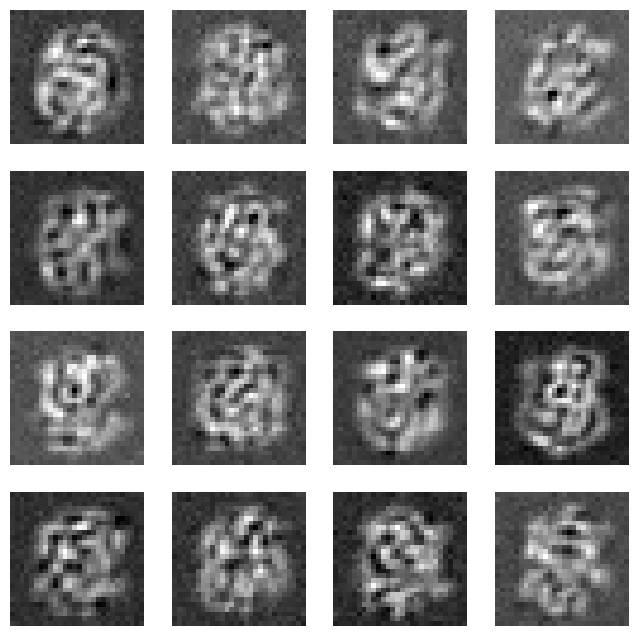

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTModel, ViTConfig
import matplotlib.pyplot as plt

# Step 1: Prepare the Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Step 2: Define the Vision Transformer Model
class SmallViTGenerator(nn.Module):
    def __init__(self, hidden_size=128, img_size=28, patch_size=7, num_channels=1, num_classes=10):
        super(SmallViTGenerator, self).__init__()
        self.config = ViTConfig(
            hidden_size=hidden_size,
            image_size=img_size,
            patch_size=patch_size,
            num_channels=num_channels,
            num_hidden_layers=4,
            num_attention_heads=2,
            intermediate_size=512,
        )
        self.vit = ViTModel(self.config)
        self.fc = nn.Linear(hidden_size, img_size * img_size * num_channels)

    def forward(self, x):
        x = self.vit(x).last_hidden_state
        x = x[:, 0]
        x = self.fc(x)
        x = x.view(-1, 1, 28, 28)
        return x

model = SmallViTGenerator()

# Step 3: Define Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Train the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 1

for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)
        loss = criterion(output, data)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Step 5: Generate Images
model.eval()
with torch.no_grad():
    noise = torch.randn(16, 1, 28, 28).to(device)
    generated_images = model(noise).cpu()

# Display generated images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i].squeeze(), cmap='gray')
    ax.axis('off')

plt.show()
